<a href="https://colab.research.google.com/github/Roarou/Computational-control/blob/main/COCO_Tutorial_MPC2_sol.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stability with terminal state constraint
We have the following LTI dynamics

$$ x_{k+1} = A\, x_k + B \,u_k  = \left[\begin{smallmatrix} 1 & 0.05 \\ 0.2 & 1.2 \end{smallmatrix}\right] x_k + \left[\begin{smallmatrix}  0.3 & 0\\ 0 & 1\end{smallmatrix}\right] u_k.$$

Solve the following optimal control problem (OPC)

\begin{array}{ll} \mbox{minimize} & \sum_{k=0}^{K-1} x_k^T Q x_k +  \, u_k^T R u_k\\
\mbox{subject to} & x_{k+1} = Ax_k + Bu_k\\%, \quad k=0, \ldots, K-1\\
& \| u_k\|_{2}\leq 6, \quad x_K= 0,
%, \quad \quad k=0, \ldots, K
\end{array}

with $Q = \left[\begin{smallmatrix} 0.2 & 0 \\ 0 & 0.15 \end{smallmatrix}\right]$ and $R = \left[\begin{smallmatrix} 2 & 0 \\ 0 & 1.1 \end{smallmatrix}\right]$.

**Question 1:**

Is the LTI system stable?

**Answer 1:** 

No, it is unstable. The eigenvalues of the A matrix are: $\lambda_1 = 0.959$ and 
$\lambda_2 = 1.241$. You can easily check this by hand calculation or the follwing code below, as the real part is positive.


In [1]:
import numpy as np

A = np.array([[1,0.05], [0.2,1.2]])
print(np.linalg.eigvals(A).round(3))

[0.959 1.241]


### Exercise 1
Solve the OPC above in a receding-horizon fashion and compare the outputs to the open-loop trajectories for a control horizon of $T=10$.

Start with the initial condition $x_0 = \left[\begin{smallmatrix} 5 \\ -8 \end{smallmatrix}\right]$ and compare the outputs for different prediction horizon lengths of $K = 3, 5, 7, 10 $. 


For plotting the open-loop and closed-loop trajectories you can use the following lines of code:

```
fig, axs = plt.subplots(nrows=1, ncols=2)
axs[0].plot(x_open[0,:], x_open[1,:], marker = 'x')
axs[1].plot(x_traj[0,:], x_traj[1,:], marker = 'x')
```



Text(0.5, 1.0, 'Closed-loop')

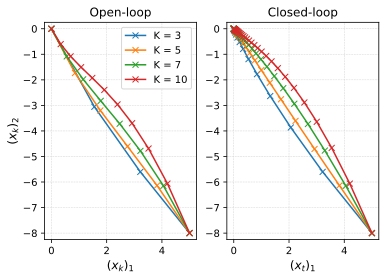

In [ ]:
import cvxpy as cp
import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'svg'

# Generate data for control problem.

n_x, n_u = 2,2

A = np.array([[1,0.05], [0.2,1.2]])
B = np.array([[0.3, 0], [0, 1]])

Q = np.array([[0.2,0], [0,0.15]])
R = np.array([[2,0], [0,1.1]])

#%% Closed-loop
   
T = 40 # Control horizon
K_all = 3,5,7,10

fig, axs = plt.subplots(nrows=1, ncols=2)

for K in K_all:
    
    x_0 = np.array([5,-8])
  
    x_traj = np.zeros([n_x, T+1]) 
    u_traj =  np.zeros([n_u, T])

    x_traj[:, 0] = x_0
    
    
    for t in range(T):
        
        x = cp.Variable((n_x, K + 1))
        u = cp.Variable((n_u, K))
        
        cost = 0
        constr = []
        for k in range(K):
            cost +=  cp.quad_form(x[:, k],Q) + cp.quad_form(u[:, k],R) 
            constr += [x[:, k + 1] == A @ x[:, k] + B @ u[:, k], cp.norm(u[:, k], 2) <= 6]
        # sums problem objectives and concatenates constraints.
        constr += [x[:, K] == 0, x[:, 0] == x_0]
        problem = cp.Problem(cp.Minimize(cost), constr)
        problem.solve(verbose = True)
        
        if t == 0:
            x_open = x.value.copy()
            u_open = u.value.copy()        
        
        x_0 = A @ x_0 + B @ u[:,0].value
        
        u_traj[:, t] = u[:,0].value
        x_traj[:, t+1] = x_0

    
    axs[0].plot(x_open[0,:], x_open[1,:], marker = 'x')
    axs[1].plot(x_traj[0,:], x_traj[1,:], marker = 'x')


axs[0].set_ylim([-8.25,0.25])
axs[0].set_xlim([-0.25,5.25])
axs[1].set_ylim([-8.25,0.25])
axs[1].set_xlim([-0.25,5.25])

axs[0].grid(which='both', axis='both',color='lightgrey', linestyle='--', linewidth=0.5)
axs[0].set_ylabel(r"$(x_k)_2$", fontsize=12)
axs[0].set_xlabel(r"$(x_k)_1$", fontsize=12)
axs[0].set_title('Open-loop', fontsize=12)
axs[0].legend(['K = ' + str(K_all[0]), 'K = ' + str(K_all[1]), 'K = ' + str(K_all[2]),'K = ' + str(K_all[3])]
              ,fontsize=10)

axs[1].grid(which='both', axis='both',color='lightgrey', linestyle='--', linewidth=0.5)
axs[1].set_xlabel(r"$(x_t)_1$", fontsize=12)
axs[1].set_title('Closed-loop', fontsize=12)
    

**Question 2:**

Do the open and closed-loop trajectories match? If not, explain in your own words why this is not the case.



**Question 3:**

Do both the open and closed-loop trajectories converge to the zero terminal state? Is the closed-loop system stable? Check the MPC stability results discussed in the lecture. 

**Answer 3:**

The closed-loop trajectory does not reach zero at the terminal state. This is due to the fact that the control horizon $T=10$ is rather short and the stability result only holds asymptotically as $T \to \infty$. But the system is asymptotically stable due to the terminal state constraint as stated in the Theorem Slide 24 of the MPC lecture.

**Question 4:**

Does the convergence to the zero terminal state improve or detioriorate with a longer prediction horizon? Why is that so?

**Asnwer 4:**

Counterintuitively, the terminal state is further away from the desired zero state the longer the prediction horizon $K$ gets. This is the case as at the end of the control horizon, the MPC controller still thinks it has $K$ steps to reach the zero terminal state. And if $K$ is getting larger $x_0(T)$ is further away as with a larger $K$ the controller predicts to have more time to still reach $x_K=0$.

## Optimal cost: open loop vs closed loop

The optimal cost to reach teh terminal state $x_K = 0$ from the initial state $x_0$ differs between the open-loop trajectory and the closed-loop receding horizon trajectory. The open-loop trajectory for example only takes $K$ (prediction horizon) time steps to reach the steady state whereas the closed-loop one will take $T$ (control horizon) time steps. And oftentimes it is the case that $K<< T$. So in the open-loop case we sum over a smaller amount of open loop states and inputs.




### Exercise 2:

Discuss with your group which of the two costs is lower? Does that depend on either $K$ or $T$? Try to find an intuitive explanation. Assume that both controllers reach the zero terminal state. 

After the discussion implement the OCP above for $T=20$ and different prediction horizons $K$ and compare the costs of the two controllers.

Text(0.5, 1.0, 'Closed-loop')

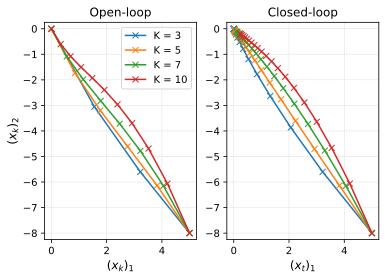

In [ ]:
#%% Closed-loop
   
T = 20 # Control horizon
K_all = 3,5,7,10

fig, axs = plt.subplots(nrows=1, ncols=2)

cost_closed = {}
cost_open = {}

for K in K_all:
    
    x_0 = np.array([5,-8])
  
    x_traj = np.zeros([n_x, T+1]) 
    u_traj =  np.zeros([n_u, T])

    x_traj[:, 0] = x_0
    
    cost_closed[K] = 0
    
    for t in range(T):
        
        x = cp.Variable((n_x, K + 1))
        u = cp.Variable((n_u, K))
        
        cost = 0
        constr = []
        for k in range(K):
            cost +=  cp.quad_form(x[:, k],Q) + cp.quad_form(u[:, k],R) 
            constr += [x[:, k + 1] == A @ x[:, k] + B @ u[:, k], cp.norm(u[:, k], 2) <= 6]
        # sums problem objectives and concatenates constraints.
        constr += [x[:, K] == 0, x[:, 0] == x_0]
        problem = cp.Problem(cp.Minimize(cost), constr)
        problem.solve()
        
        if t == 0:
            cost_open[K] = problem.value
            x_open = x.value.copy()
            u_open = u.value.copy()      
        
        cost_closed[K] +=  x_0.T @ Q @ x_0 + u[:,0].value.T @ R @ u[:,0].value
        
        x_0 = A @ x_0 + B @ u[:,0].value
        
        u_traj[:, t] = u[:,0].value
        x_traj[:, t+1] = x_0
      
        
    
    axs[0].plot(x_open[0,:], x_open[1,:], marker = 'x')
    axs[1].plot(x_traj[0,:], x_traj[1,:], marker = 'x')


axs[0].set_ylim([-8.25,0.25])
axs[0].set_xlim([-0.25,5.25])
axs[1].set_ylim([-8.25,0.25])
axs[1].set_xlim([-0.25,5.25])

axs[0].grid(which='both', axis='both',color='lightgrey', linestyle='--', linewidth=0.5)
axs[0].set_ylabel(r"$(x_k)_2$", fontsize=12)
axs[0].set_xlabel(r"$(x_k)_1$", fontsize=12)
axs[0].set_title('Open-loop', fontsize=12)
axs[0].legend(['K = ' + str(K_all[0]), 'K = ' + str(K_all[1]), 'K = ' + str(K_all[2]),'K = ' + str(K_all[3])]
              ,fontsize=10)

axs[1].grid(which='both', axis='both',color='lightgrey', linestyle='--', linewidth=0.5)
axs[1].set_xlabel(r"$(x_t)_1$", fontsize=12)
axs[1].set_title('Closed-loop', fontsize=12)
    

Now compare the costs:

In [ ]:
print(cost_open)
print(cost_closed)

{3: 184.22463261495054, 5: 117.26961611359823, 7: 93.51500025947901, 10: 79.58540676401425}
{3: 118.17506575814934, 5: 83.78769020691293, 7: 74.71365442458348, 10: 70.6055762818655}
